In [6]:
import sys
sys.path.insert(1, '../SyMBac/')

from SyMBac.drawing import raster_cell
from SyMBac.PSF import PSF_generator
from SyMBac.renderer import convolve_rescale
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm
from PIL import Image
from skimage.util import img_as_uint
from joblib import Parallel, delayed
from skimage.transform import rotate
from SyMBac.PSF import Camera
from numba import njit

In [198]:
@njit
def generate_deviation_from_CL(centreline, thickness):
    return np.arange(thickness) + centreline - int(np.ceil(thickness ))

@njit
def gen_3D_coords_from_2D(test_cells, centreline, thickness):
    return np.where(test_cells == thickness) + (generate_deviation_from_CL(centreline, thickness),)

@njit
def convert_to_3D_numba(cell):
    expanded_scene = cell
    volume_shape = expanded_scene.shape[0:] + (int(expanded_scene.max()*2),)
    test_cells = rounder(expanded_scene)
    centreline = int(expanded_scene.max() )
    cells_3D = np.zeros(volume_shape,dtype = np.ubyte)
    for t in range(int(expanded_scene.max() *2 )):
        test_coords = gen_3D_coords_from_2D(test_cells, centreline, t)
        for x, y in zip(test_coords[0], (test_coords[1])):
            for z in test_coords[2]:
                cells_3D[x, y, z] = 1
    return cells_3D


@njit
def rounder(x):
    out = np.empty_like(x)
    np.round(x, 0, out)
    return out


def convert_to_3D(cell):
    cells_3D = convert_to_3D_numba(cell)
    cells_3D = np.moveaxis(cells_3D, -1, 0)
    cells_3D[cells_3D.shape[0]//2:,:, :] = cells_3D[:cells_3D.shape[0]//2,:, :][::-1]
    return cells_3D
    #cells_3D = np.pad(cells_3D, ((100,100), (50,50), (50,50)))
#cells_3D.shape

def raster_cell_3d(raster_cell_length, raster_cell_width, raster_slice_amount):

    cell_1 = raster_cell(length=round(raster_cell_length/2)*2, width=round(raster_cell_width/2)*2, separation = 0)

    cell_1_3d = convert_to_3D(cell_1)
    
    cell_3d = cell_1_3d 
    
    if raster_slice_amount > 2:
        
        cell_3d = cell_3d[int(raster_slice_amount//2):-int(raster_slice_amount//2),:,:]
    
    return cell_3d

In [199]:
a_cell = raster_cell_3d(100,100, 100*0.1)

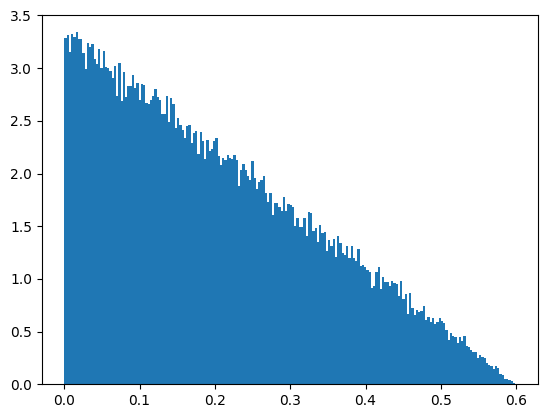

In [200]:
h = plt.hist(np.random.triangular(0, 0, 0.6, 100000), bins=200,
             density=True)

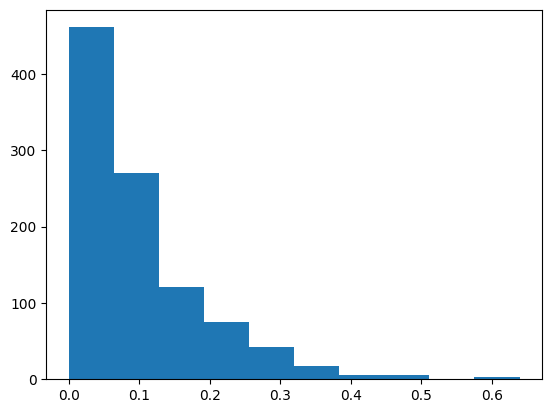

In [209]:
h = plt.hist(np.random.exponential(scale=0.1, size=1000))

In [257]:
def generate_agar_pad_image(border, img_size, density, iter_threshold, projection):
    if projection == "on":
        projection_amount = 0
    if projection == "off":
        projection_amount = 0.95
    
    image = np.zeros((int(img_size*pix_scaler * border), int(img_size*pix_scaler * border)))
    mask = np.zeros((int(img_size*pix_scaler * border), int(img_size*pix_scaler * border)))
    mask_labaled = np.zeros((int(img_size*pix_scaler * border), int(img_size*pix_scaler * border))).astype(np.uint)
     #DENSITY In cells per square micron
    n_cells = int(density * ((pix_mic_conv * img_size) ** 2))
    mask_counter = 0
    iterations = 0
    stop_condition = int(n_cells*iter_threshold)
    #pbar = tqdm(total=stop_condition)
    cell_info = []
    while (mask_counter != n_cells) and (iterations != stop_condition):

        cell_length = np.random.uniform(2, 3.5)
        cell_width = np.random.uniform(1, cell_length/3)
        while cell_width >= cell_length:
            cell_width = np.random.uniform(1, cell_length/3)

        raster_cell_length = cell_length/pix_mic_conv * resize_amount
        raster_cell_width = cell_width/pix_mic_conv * resize_amount
        
        cell = raster_cell_3d(raster_cell_length, raster_cell_width,raster_cell_width*projection_amount ).sum(axis=0)
        cell = rotate(cell, angle=np.random.uniform(0,365), resize=True, order = 0, preserve_range = True)
        cell *= 1300
        #

        cell = cell.astype(int)
        cell_mask = cell > 0
        pos_x_start = int(np.random.uniform(0, image.shape[1] - cell.shape[1]))
        pos_y_start = int(np.random.uniform(0, image.shape[0] - cell.shape[0]))
        if mask[pos_y_start + cell.shape[0]//2, pos_x_start + cell.shape[1]//2]:
            pass
        else:

            mask[pos_y_start:pos_y_start+cell.shape[0], pos_x_start:pos_x_start+cell.shape[1]] += cell_mask
            if np.sum(mask > 1) > 0:
                mask[pos_y_start:pos_y_start+cell.shape[0], pos_x_start:pos_x_start+cell.shape[1]] -= cell_mask
            else:
                image[pos_y_start:pos_y_start+cell.shape[0], pos_x_start:pos_x_start+cell.shape[1]] += cell
                mask_labaled[pos_y_start:pos_y_start+cell.shape[0], pos_x_start:pos_x_start+cell.shape[1]] += (cell_mask * mask_counter).astype(np.uint)
                cell_info.append([mask_counter, cell_length, cell_width])
                mask_counter += 1
                
        iterations += 1
        #pbar.update(1)
    #pbar.close()

    return image, mask_labaled, cell_info

In [258]:
pad_amount = 200

radius = 150
wavelength = 0.6
NA = 1.45
n = 1.518
resize_amount = 1
pix_scaler = 3
pix_mic_conv = 0.065 / pix_scaler
apo_sigma = 11

FL_PSF = PSF_generator(
    radius = radius,
    wavelength = wavelength,
    NA = NA,
    n = n,
    resize_amount = resize_amount,
    pix_mic_conv = pix_mic_conv,
    apo_sigma = apo_sigma,
    mode="3d fluo",
    condenser = "Ph3",
    z_height = int(round(1/pix_mic_conv)),
    pz = 0.5,
    working_distance = 170
)
FL_PSF.calculate_PSF()
FL_PSF.kernel = np.sum(FL_PSF.kernel, axis=0)
FL_PSF.kernel /= FL_PSF.kernel.max()

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

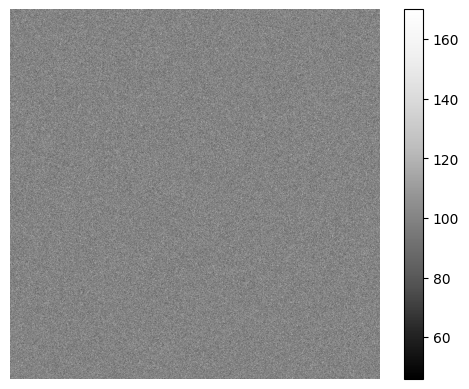

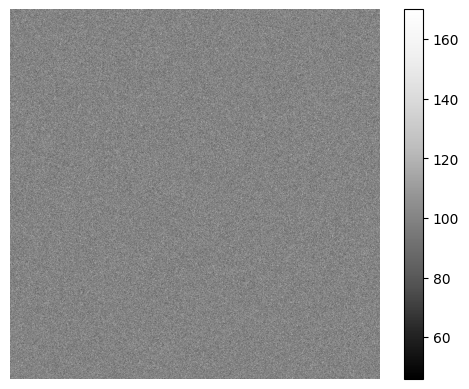

/home/georgeos/miniconda3/lib/python3.10/site-packages/skimage/util/dtype.py:492: UserWarning: Downcasting uint64 to uint16 without scaling because max value 97 fits in uint16
  return _convert(image, np.uint16, force_copy)


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

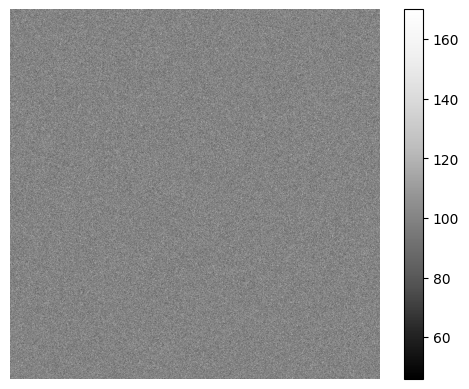

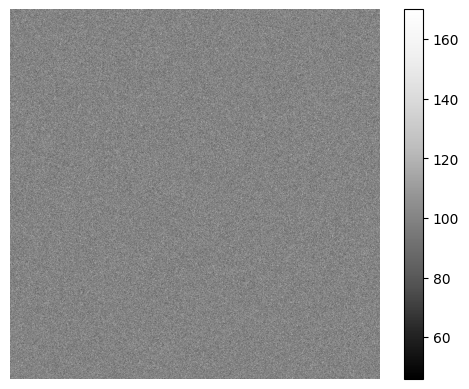

/home/georgeos/miniconda3/lib/python3.10/site-packages/skimage/util/dtype.py:492: UserWarning: Downcasting uint64 to uint16 without scaling because max value 96 fits in uint16
  return _convert(image, np.uint16, force_copy)


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

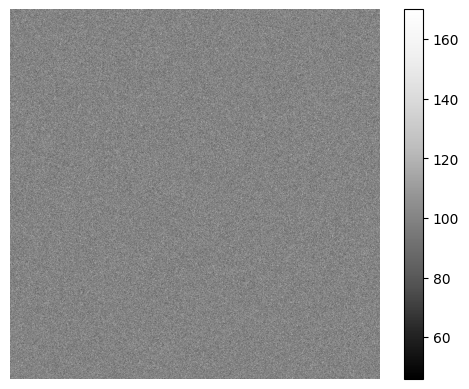

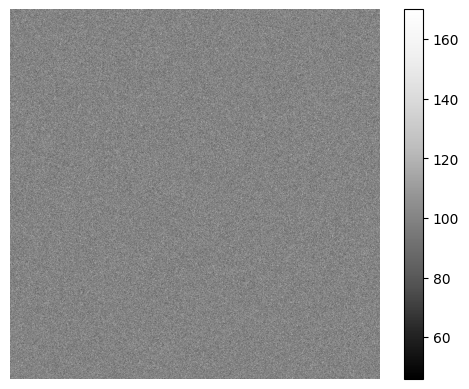

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

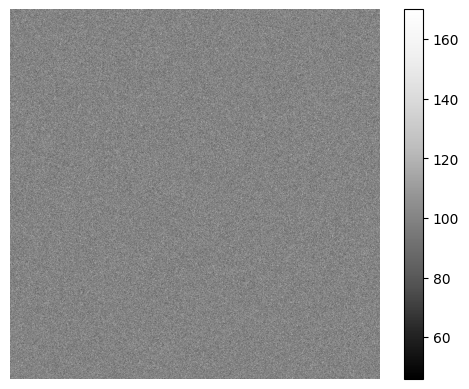

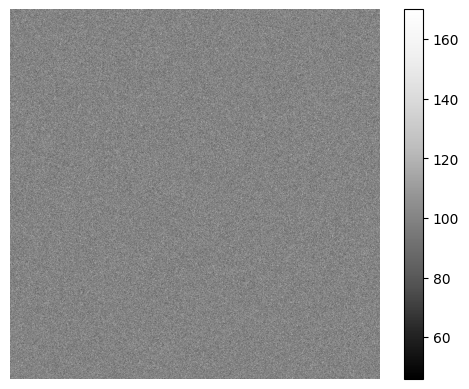

In [260]:
wavelengths = [0.2, 0.6]
projections = ["on", "off"]
for wavelength in wavelengths:
    for projection in projections:
        
        
        pad_amount = 200

        radius = 150
        wavelength = wavelength
        NA = 1.45
        n = 1.518
        resize_amount = 1
        pix_scaler = 3
        pix_mic_conv = 0.065 / pix_scaler
        apo_sigma = 11

        FL_PSF = PSF_generator(
            radius = radius,
            wavelength = wavelength,
            NA = NA,
            n = n,
            resize_amount = resize_amount,
            pix_mic_conv = pix_mic_conv,
            apo_sigma = apo_sigma,
            mode="3d fluo",
            condenser = "Ph3",
            z_height = int(round(1/pix_mic_conv)),
            pz = 0.5,
            working_distance = 170
        )
        FL_PSF.calculate_PSF()
        FL_PSF.kernel = np.sum(FL_PSF.kernel, axis=0)
        FL_PSF.kernel /= FL_PSF.kernel.max()
        
        
        densities = np.random.uniform(0.21, 0.22, 2)
        img_mask_pairs = Parallel(n_jobs=-1)(delayed(generate_agar_pad_image)(1, 1000, density, 2, projection) for density in tqdm(densities)) 
        
        conv_imgs = []
        for a, (image, mask, cell_info) in enumerate(tqdm(img_mask_pairs)):
            my_camera = Camera(baseline=100, sensitivity=2.9, dark_noise=8)
            dark_image = my_camera.render_dark_image(size=(1000,1000));
            conv_image = convolve_rescale(image, FL_PSF.kernel, rescale_factor=1/pix_scaler, rescale_int=True)
            conv_image = (dark_image + conv_image * 1000)
            conv_image /= conv_image.max()
            conv_imgs.append(conv_image)
            Image.fromarray(img_as_uint(conv_image/conv_image.max())).save(f"projection_analysis/training_data/{projection}_{wavelength}_{str(a).zfill(4)}.png")
            Image.fromarray(img_as_uint(mask)).save(f"projection_analysis/training_data/{projection}_{wavelength}_{str(a).zfill(4)}_masks.png")
            Image.fromarray(img_as_uint(image/image.max())).save(f"projection_analysis/raw_images/{projection}_{wavelength}_{str(a).zfill(4)}.png")
            #np.save(f"raw_images/{str(a).zfill(4)}.npy", np.array(cell_info))

In [235]:
densities = np.random.uniform(0.01, 0.15, 10)

In [236]:
img_mask_pairs = Parallel(n_jobs=-1)(delayed(generate_agar_pad_image)(1, 1000, density, 2, "on") for density in tqdm(densities)) 

  0%|          | 0/10 [00:00<?, ?it/s]

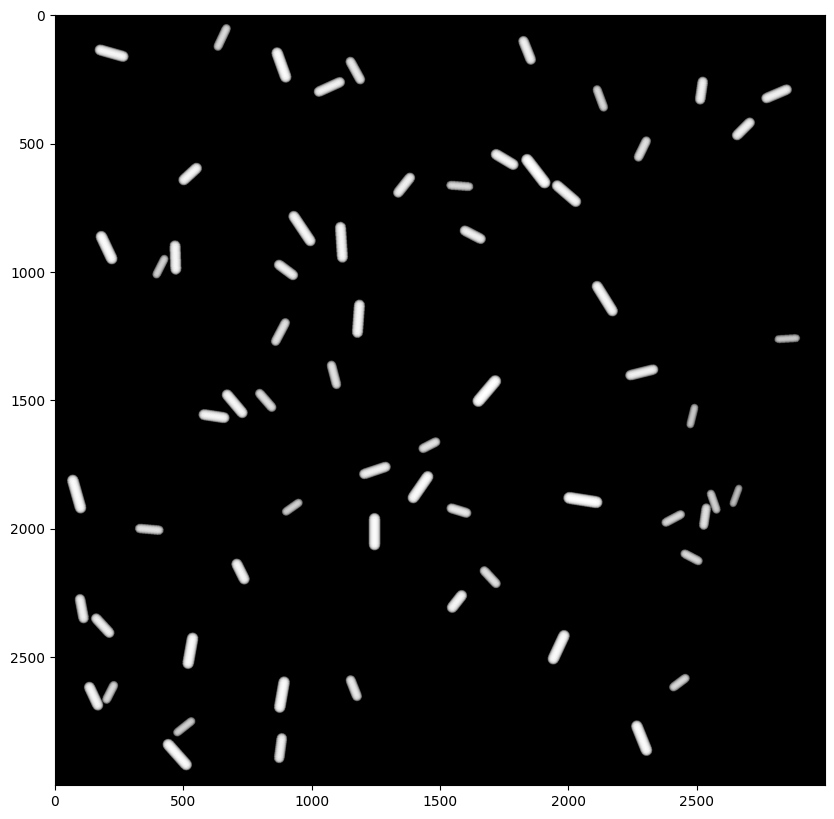

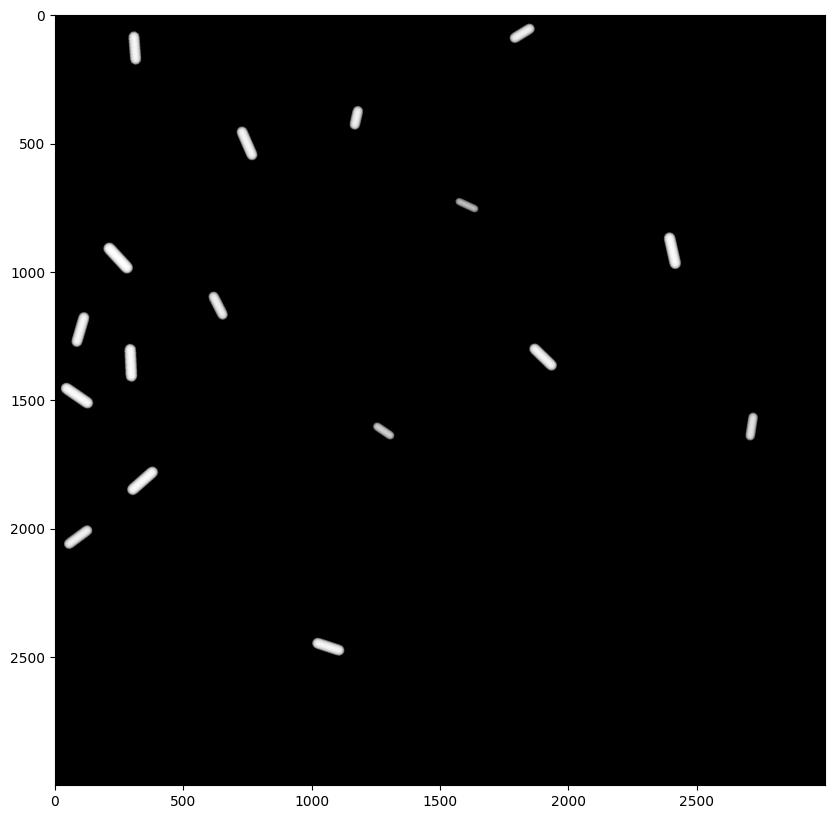

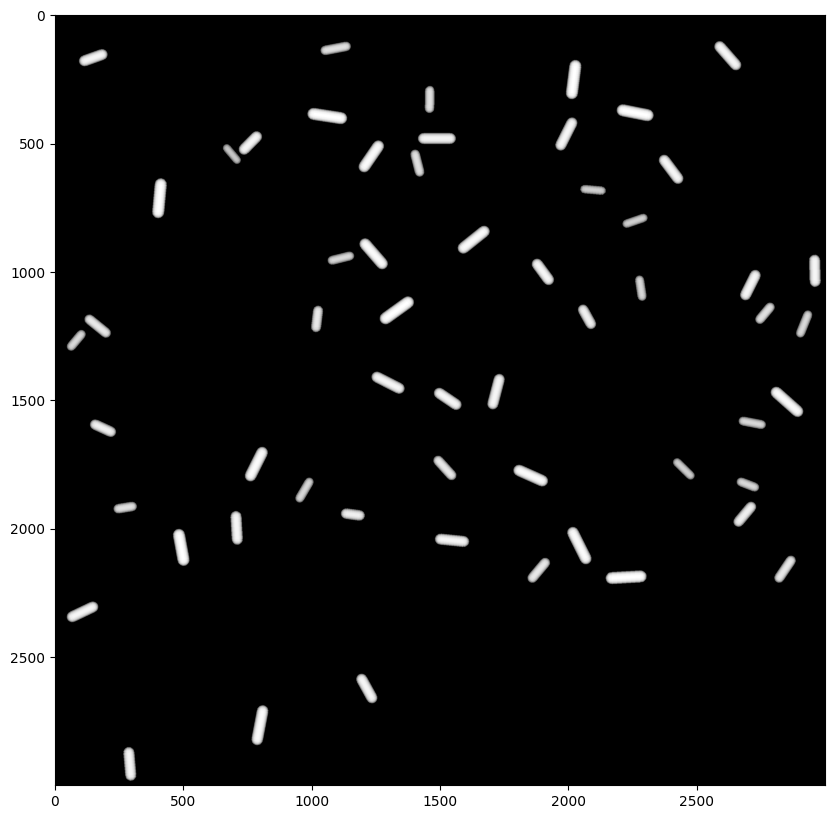

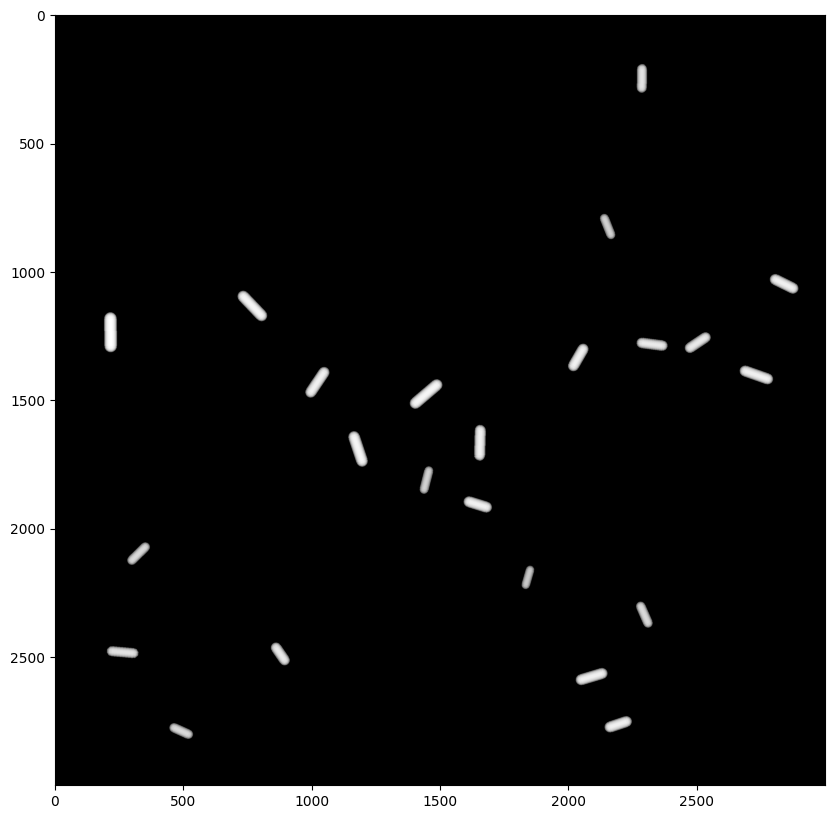

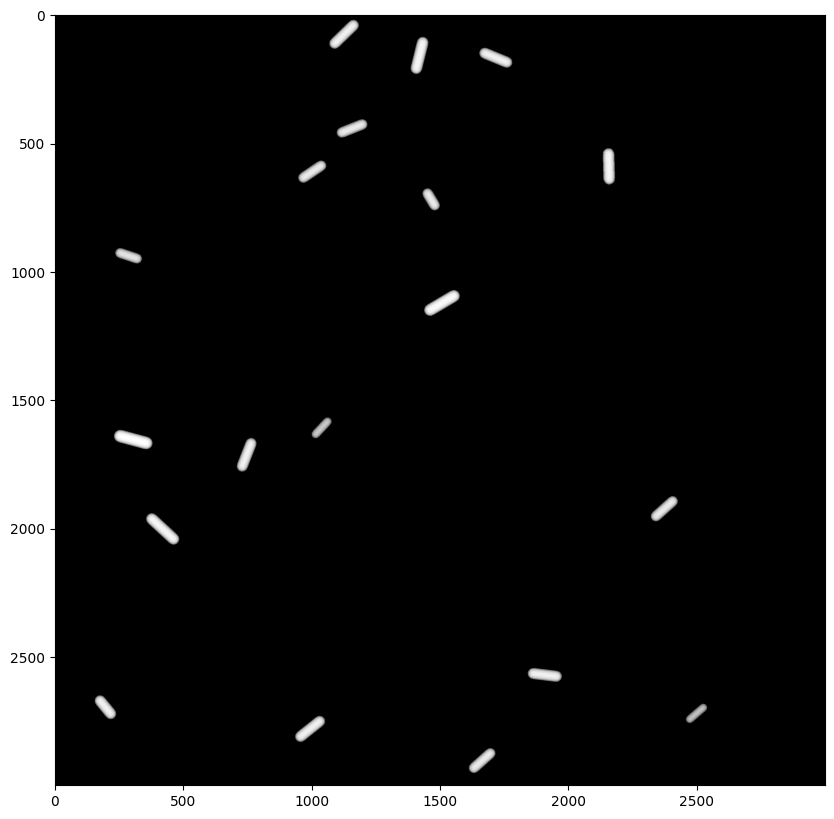

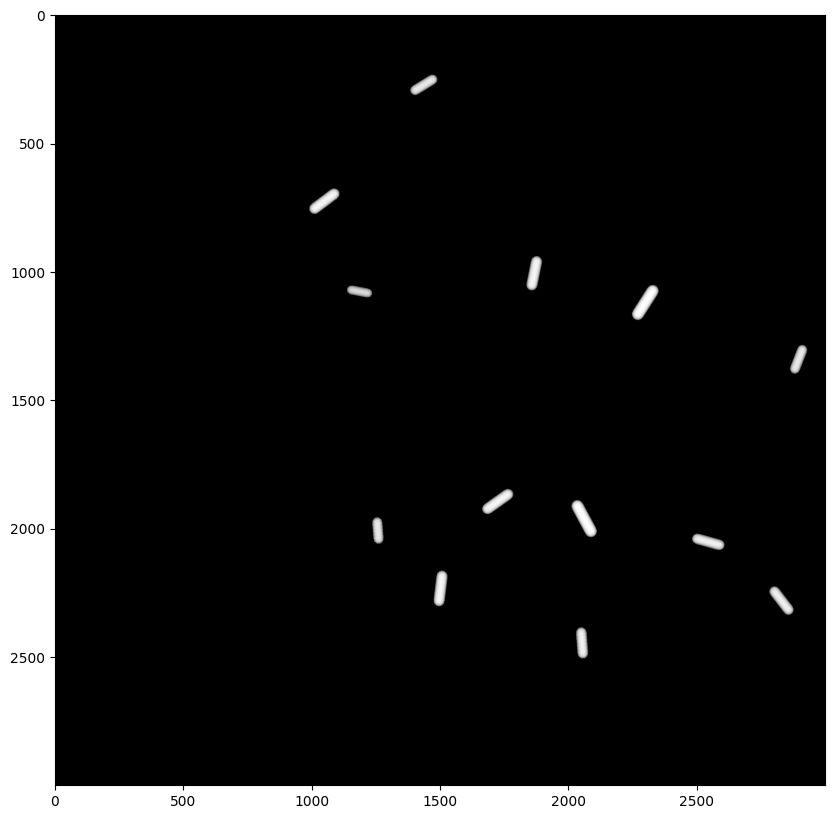

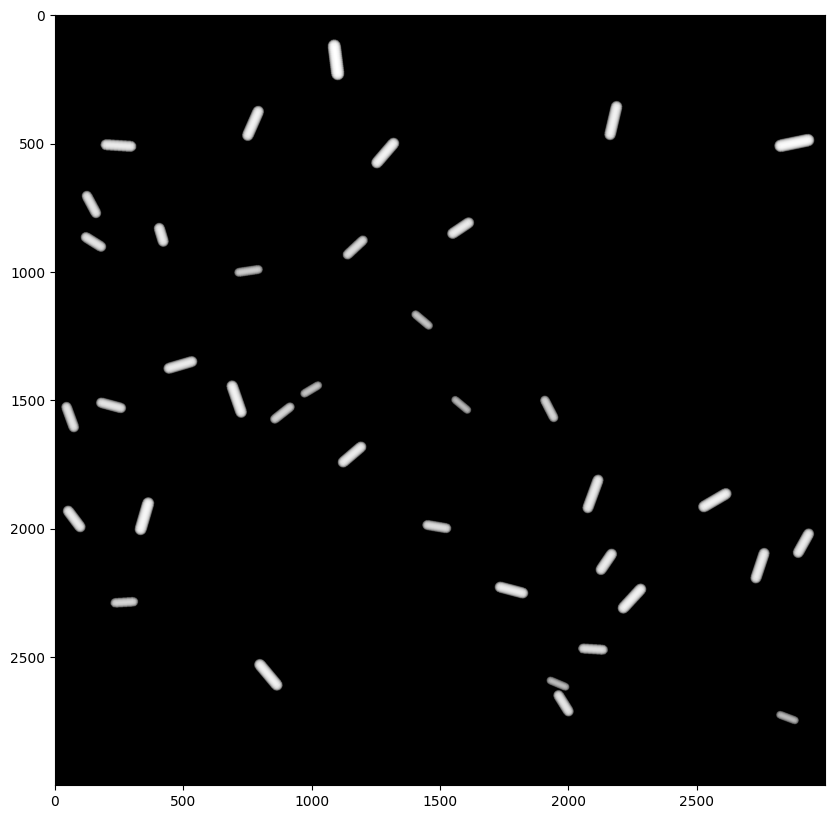

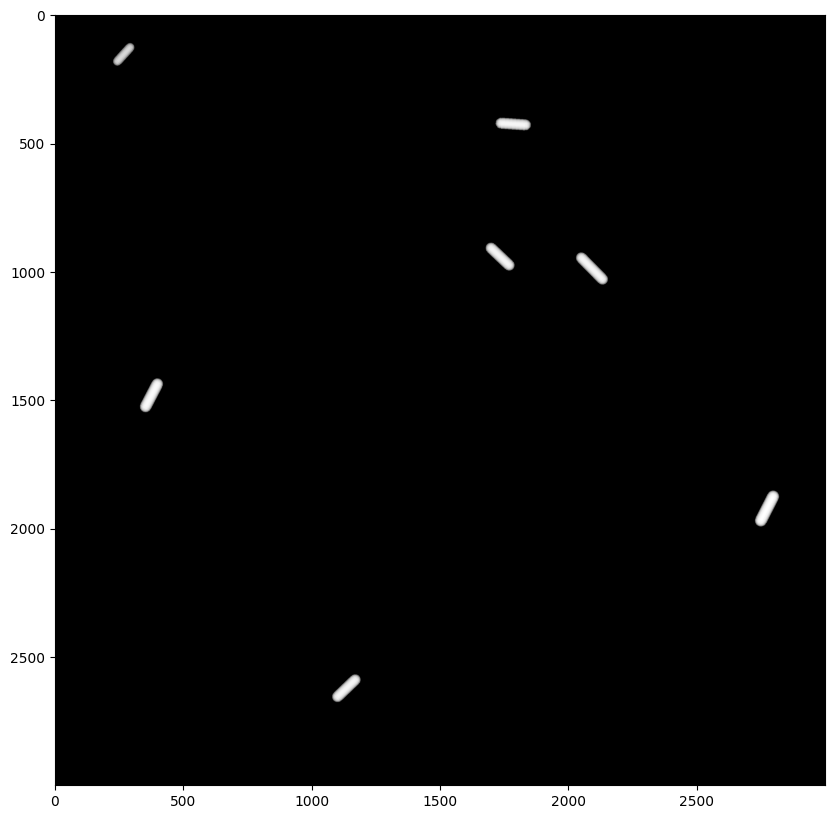

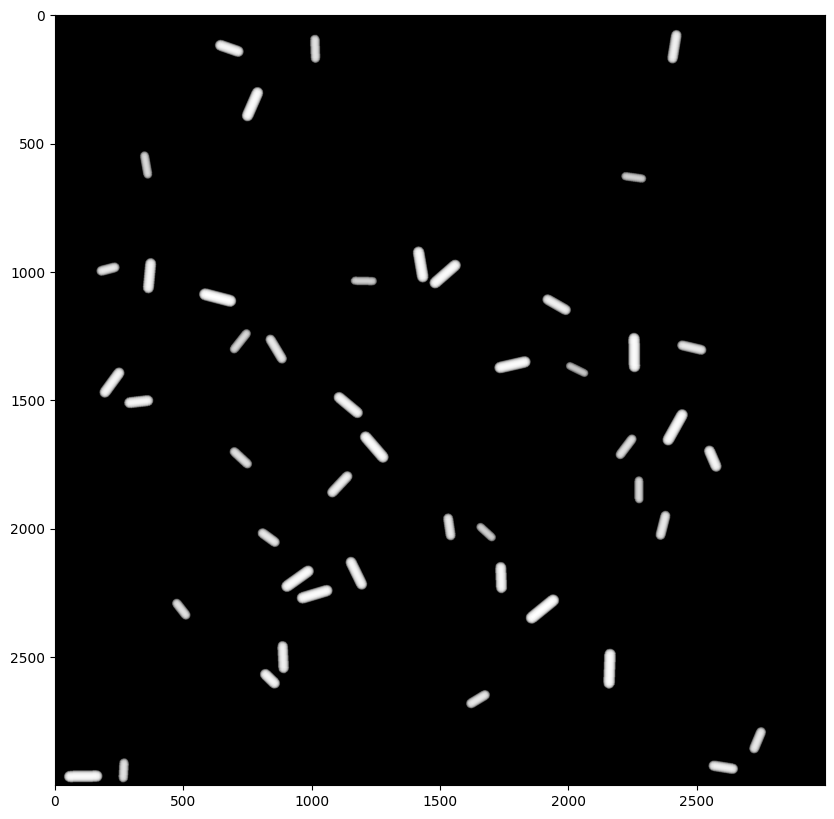

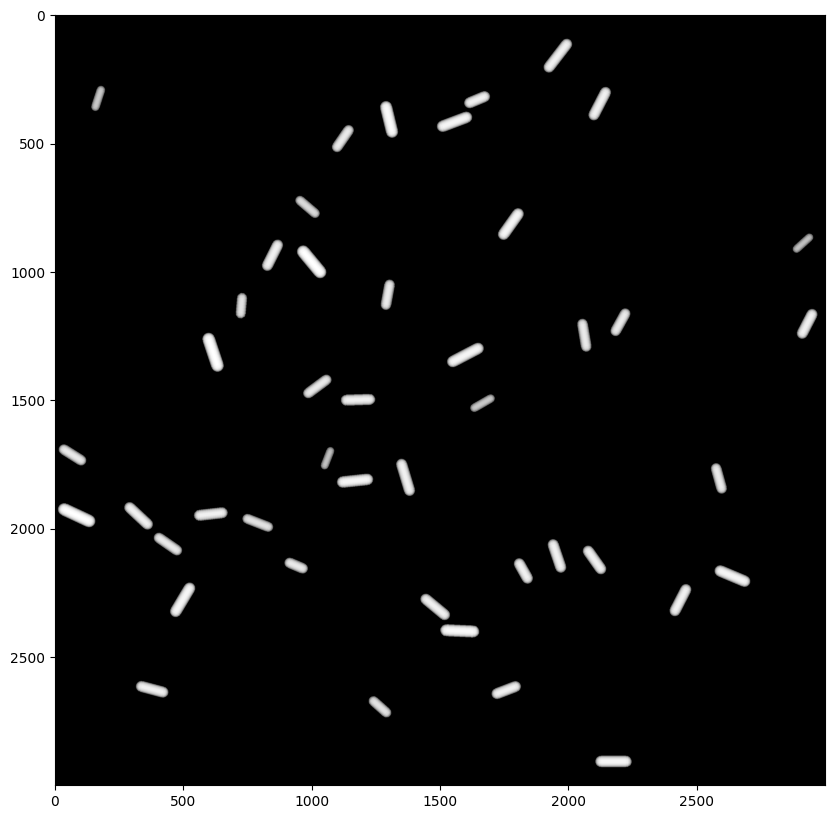

In [231]:
for img, mask, cell_info in img_mask_pairs:
    plt.figure(figsize=(10,10))
    plt.imshow(img, cmap="Greys_r")
    plt.show()

In [239]:
img.shape

(3000, 3000)

  0%|          | 0/10 [00:00<?, ?it/s]

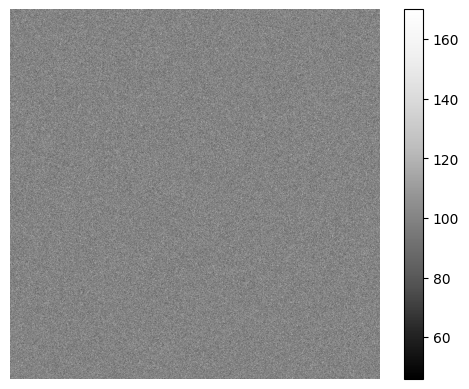

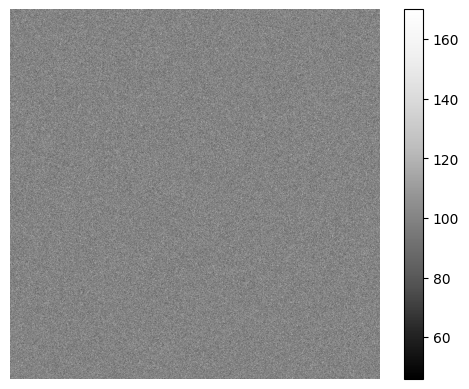

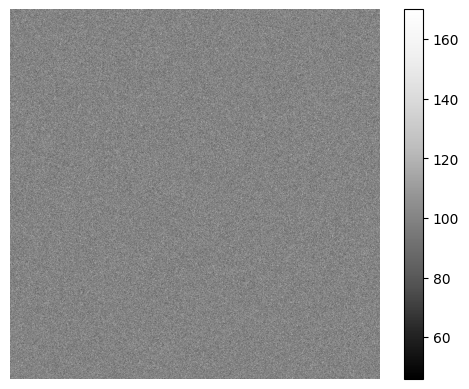

KeyboardInterrupt: 

In [247]:
conv_imgs = []
for a, (image, mask, cell_info) in enumerate(tqdm(img_mask_pairs)):
    my_camera = Camera(baseline=100, sensitivity=2.9, dark_noise=8)
    dark_image = my_camera.render_dark_image(size=(1000,1000));
    conv_image = convolve_rescale(image, FL_PSF.kernel, rescale_factor=1/pix_scaler, rescale_int=True)
    conv_image = (dark_image + conv_image * 1000)
    conv_image /= conv_image.max()
    conv_imgs.append(conv_image)
    #Image.fromarray(img_as_uint(conv_image/conv_image.max())).save(f"training_data/{str(a).zfill(4)}.png")
    #Image.fromarray(img_as_uint(mask)).save(f"training_data/{str(a).zfill(4)}_masks.png")
    #Image.fromarray(img_as_uint(image/image.max())).save(f"raw_images/{str(a).zfill(4)}.png")
    #np.save(f"raw_images/{str(a).zfill(4)}.npy", np.array(cell_info))

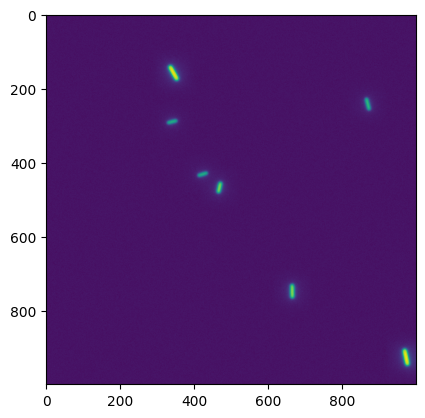

In [248]:
plt.imshow(conv_imgs[0])

In [21]:
#for a, (image, mask, cell_info) in enumerate(tqdm(img_mask_pairs)):
def generate_test_data(a, image, mask, cell_info):
    my_camera = Camera(baseline=100, sensitivity=2.9, dark_noise=8)
    dark_image = my_camera.render_dark_image(size=image.shape);
    conv_image = convolve_rescale(image, FL_PSF.kernel, rescale_factor=1/pix_scaler, rescale_int=True)
    conv_image = (dark_image + conv_image * 1000)
    conv_image /= conv_image.max()
    Image.fromarray(img_as_uint(conv_image/conv_image.max())).save(f"test_data/{str(a).zfill(4)}.png")
    Image.fromarray(img_as_uint(mask)).save(f"test_data/{str(a).zfill(4)}_masks.png")
    Image.fromarray(img_as_uint(image/image.max())).save(f"raw_test_images/{str(a).zfill(4)}.png")
    np.save(f"raw_test_images/{str(a).zfill(4)}.npy", np.array(cell_info))

In [22]:
img_mask_pairs = Parallel(n_jobs=-1)(delayed(generate_agar_pad_image)(1, 1000, density, 2) for density in tqdm(densities)) 

  0%|          | 0/100 [00:00<?, ?it/s]

In [23]:
_ = Parallel(n_jobs=-1)(delayed(generate_test_data)(a, image, mask, cell_info) for a , (image, mask, cell_info) in enumerate(tqdm(img_mask_pairs)))

  0%|          | 0/100 [00:00<?, ?it/s]

/home/georgeos/miniconda3/lib/python3.10/site-packages/skimage/util/dtype.py:492: UserWarning: Downcasting uint64 to uint16 without scaling because max value 569 fits in uint16
  return _convert(image, np.uint16, force_copy)


Figure(640x480)


/home/georgeos/miniconda3/lib/python3.10/site-packages/skimage/util/dtype.py:492: UserWarning: Downcasting uint64 to uint16 without scaling because max value 287 fits in uint16
  return _convert(image, np.uint16, force_copy)
/home/georgeos/miniconda3/lib/python3.10/site-packages/skimage/util/dtype.py:492: UserWarning: Downcasting uint64 to uint16 without scaling because max value 48 fits in uint16
  return _convert(image, np.uint16, force_copy)
/home/georgeos/miniconda3/lib/python3.10/site-packages/skimage/util/dtype.py:492: UserWarning: Downcasting uint64 to uint16 without scaling because max value 183 fits in uint16
  return _convert(image, np.uint16, force_copy)
/home/georgeos/miniconda3/lib/python3.10/site-packages/skimage/util/dtype.py:492: UserWarning: Downcasting uint64 to uint16 without scaling because max value 398 fits in uint16
  return _convert(image, np.uint16, force_copy)
/home/georgeos/miniconda3/lib/python3.10/site-packages/skimage/util/dtype.py:492: UserWarning: Downca

Figure(640x480)
Figure(640x480)
Figure(640x480)
Figure(640x480)
Figure(640x480)
Figure(640x480)


/home/georgeos/miniconda3/lib/python3.10/site-packages/skimage/util/dtype.py:492: UserWarning: Downcasting uint64 to uint16 without scaling because max value 176 fits in uint16
  return _convert(image, np.uint16, force_copy)


Figure(640x480)
Figure(640x480)
Figure(640x480)
Figure(640x480)


/home/georgeos/miniconda3/lib/python3.10/site-packages/skimage/util/dtype.py:492: UserWarning: Downcasting uint64 to uint16 without scaling because max value 463 fits in uint16
  return _convert(image, np.uint16, force_copy)
/home/georgeos/miniconda3/lib/python3.10/site-packages/skimage/util/dtype.py:492: UserWarning: Downcasting uint64 to uint16 without scaling because max value 350 fits in uint16
  return _convert(image, np.uint16, force_copy)
/home/georgeos/miniconda3/lib/python3.10/site-packages/skimage/util/dtype.py:492: UserWarning: Downcasting uint64 to uint16 without scaling because max value 471 fits in uint16
  return _convert(image, np.uint16, force_copy)
/home/georgeos/miniconda3/lib/python3.10/site-packages/skimage/util/dtype.py:492: UserWarning: Downcasting uint64 to uint16 without scaling because max value 318 fits in uint16
  return _convert(image, np.uint16, force_copy)


Figure(640x480)
Figure(640x480)


/home/georgeos/miniconda3/lib/python3.10/site-packages/skimage/util/dtype.py:492: UserWarning: Downcasting uint64 to uint16 without scaling because max value 65 fits in uint16
  return _convert(image, np.uint16, force_copy)
/home/georgeos/miniconda3/lib/python3.10/site-packages/skimage/util/dtype.py:492: UserWarning: Downcasting uint64 to uint16 without scaling because max value 82 fits in uint16
  return _convert(image, np.uint16, force_copy)
/home/georgeos/miniconda3/lib/python3.10/site-packages/skimage/util/dtype.py:492: UserWarning: Downcasting uint64 to uint16 without scaling because max value 194 fits in uint16
  return _convert(image, np.uint16, force_copy)
/home/georgeos/miniconda3/lib/python3.10/site-packages/skimage/util/dtype.py:492: UserWarning: Downcasting uint64 to uint16 without scaling because max value 99 fits in uint16
  return _convert(image, np.uint16, force_copy)
/home/georgeos/miniconda3/lib/python3.10/site-packages/skimage/util/dtype.py:492: UserWarning: Downcast

Figure(640x480)
Figure(640x480)
Figure(640x480)
Figure(640x480)
Figure(640x480)
Figure(640x480)


/home/georgeos/miniconda3/lib/python3.10/site-packages/skimage/util/dtype.py:492: UserWarning: Downcasting uint64 to uint16 without scaling because max value 468 fits in uint16
  return _convert(image, np.uint16, force_copy)
/home/georgeos/miniconda3/lib/python3.10/site-packages/skimage/util/dtype.py:492: UserWarning: Downcasting uint64 to uint16 without scaling because max value 435 fits in uint16
  return _convert(image, np.uint16, force_copy)
/home/georgeos/miniconda3/lib/python3.10/site-packages/skimage/util/dtype.py:492: UserWarning: Downcasting uint64 to uint16 without scaling because max value 245 fits in uint16
  return _convert(image, np.uint16, force_copy)
/home/georgeos/miniconda3/lib/python3.10/site-packages/skimage/util/dtype.py:492: UserWarning: Downcasting uint64 to uint16 without scaling because max value 440 fits in uint16
  return _convert(image, np.uint16, force_copy)


Figure(640x480)
Figure(640x480)
Figure(640x480)
Figure(640x480)
Figure(640x480)
Figure(640x480)


/home/georgeos/miniconda3/lib/python3.10/site-packages/skimage/util/dtype.py:492: UserWarning: Downcasting uint64 to uint16 without scaling because max value 460 fits in uint16
  return _convert(image, np.uint16, force_copy)
/home/georgeos/miniconda3/lib/python3.10/site-packages/skimage/util/dtype.py:492: UserWarning: Downcasting uint64 to uint16 without scaling because max value 436 fits in uint16
  return _convert(image, np.uint16, force_copy)
/home/georgeos/miniconda3/lib/python3.10/site-packages/skimage/util/dtype.py:492: UserWarning: Downcasting uint64 to uint16 without scaling because max value 581 fits in uint16
  return _convert(image, np.uint16, force_copy)


Figure(640x480)
Figure(640x480)
Figure(640x480)
Figure(640x480)
Figure(640x480)
Figure(640x480)


/home/georgeos/miniconda3/lib/python3.10/site-packages/skimage/util/dtype.py:492: UserWarning: Downcasting uint64 to uint16 without scaling because max value 586 fits in uint16
  return _convert(image, np.uint16, force_copy)
/home/georgeos/miniconda3/lib/python3.10/site-packages/skimage/util/dtype.py:492: UserWarning: Downcasting uint64 to uint16 without scaling because max value 311 fits in uint16
  return _convert(image, np.uint16, force_copy)


Figure(640x480)
Figure(640x480)
Figure(640x480)
Figure(640x480)
Figure(640x480)
Figure(640x480)


/home/georgeos/miniconda3/lib/python3.10/site-packages/skimage/util/dtype.py:492: UserWarning: Downcasting uint64 to uint16 without scaling because max value 489 fits in uint16
  return _convert(image, np.uint16, force_copy)
/home/georgeos/miniconda3/lib/python3.10/site-packages/skimage/util/dtype.py:492: UserWarning: Downcasting uint64 to uint16 without scaling because max value 581 fits in uint16
  return _convert(image, np.uint16, force_copy)
/home/georgeos/miniconda3/lib/python3.10/site-packages/skimage/util/dtype.py:492: UserWarning: Downcasting uint64 to uint16 without scaling because max value 85 fits in uint16
  return _convert(image, np.uint16, force_copy)
/home/georgeos/miniconda3/lib/python3.10/site-packages/skimage/util/dtype.py:492: UserWarning: Downcasting uint64 to uint16 without scaling because max value 443 fits in uint16
  return _convert(image, np.uint16, force_copy)
/home/georgeos/miniconda3/lib/python3.10/site-packages/skimage/util/dtype.py:492: UserWarning: Downca